In [62]:
import numpy as np
from scipy.stats import beta
import pandas as pd
from matplotlib import pyplot as plt
from celluloid import Camera
import seaborn as sns
import inflect 


class Bandit:
    def __init__(self, true_probability):
        self.true_probability = true_probability
        self.alpha = 1
        self.beta = 1
        self.mean = 0.5
        
    def pull(self):
        return np.random.random() < self.true_probability

    def sample(self):
        return np.random.beta(self.alpha, self.beta)

    def update(self, reward):
        self.alpha += reward
        self.beta += (1 - reward)
        self.mean = self.alpha/(self.alpha + self.beta)
        
def Thompson(bandits, num_trials):
    rewards = np.zeros(num_trials)
    prob_dict = {i: [] for i in range(len(bandits))}
    action_list = []                                    
    for i in range(num_trials):
        # Thompson sampling
        j = np.argmax([b.sample() for b in bandits])
        action_list.append(j)
        # Pull the arm for the bandit with the largest sample
        reward = bandits[j].pull()

        # Update rewards log
        rewards[i] = reward

        # Update the distribution for the bandit whose arm we just pulled
        bandits[j].update(reward)
        [prob_dict[i].append(bandits[i].mean) for i in range(len(bandits))]
    return rewards, prob_dict, action_list

# Suppose we have 3 bandits with these true probabilities
true_probabilities = [0.505, 0.5]

bandits = [Bandit(p) for p in true_probabilities]

# Run experiment
rewards, prob_dict , action_list = Thompson(bandits, num_trials=120000)

# Print the total reward
print("Total reward earned:", rewards.sum())
print("Overall win rate:", rewards.sum() / len(rewards))


Total reward earned: 60519.0
Overall win rate: 0.504325


In [81]:
actions=pd.DataFrame(action_list, columns=['actions'])
actions.reset_index(inplace=True)
actions.rename(columns={'index':'event'}, inplace=True)

actions=pd.get_dummies(actions.actions).astype('int')
actions.cumsum()


df = pd.DataFrame()
for i in actions.columns:
    d = actions.iloc[:,i].cumsum()
    df = pd.concat([df, d], axis=1)


p = inflect.engine()
variants = [p.number_to_words(i+1) for i in df.columns]
df.columns = variants
df.reset_index(names='time_step', inplace=True)
df = pd.melt(df, id_vars=['time_step'])
df.columns=['time_step', 'variant', 'action_cnt']
df.variant = df.variant.str.capitalize()

variants = list(np.arange(1, len(true_probabilities)+1))
df

,time_step,variant,action_cnt
0,0,One,0
1,1,One,1
2,2,One,1
3,3,One,1
4,4,One,1
...,...,...,...
239995,119995,Two,17763
239996,119996,Two,17763
239997,119997,Two,17763
239998,119998,Two,17763


In [78]:


df_ab = pd.DataFrame(variants*df.time_step.max(), columns = ['variant'])

#df_ab['idx'] = np.aranage(0, len(df_ab))



#df_ab['variant'] = df_ab['variant'].apply(lambda x: p.number_to_words(x))



from itertools import cycle


#This needs to be updated to by dynamic
seq = cycle([1, 1, 2, 2])
seq2 =cycle([1,0]) 


df_ab['action'] = [next(seq) for count in range(df_ab.shape[0])]

df_ab['action'] = (df_ab.action == df_ab.variant).astype('int')
df_ab['action_cnt'] = df_ab.groupby('variant')['action'].transform(pd.Series.cumsum)
df_ab['pre_time_step'] = [next(seq2) for count in range(df_ab.shape[0])]
df_ab['time_step'] = df_ab.pre_time_step.cumsum()

df_ab = df_ab[df.columns]
df_ab['variant'] = df_ab['variant'].apply(lambda x: p.number_to_words(x))
df_ab.variant = df_ab.variant.str.capitalize()
df_ab

,time_step,variant,action_cnt
0,1,One,1
1,1,Two,0
2,2,One,1
3,2,Two,1
4,3,One,2
...,...,...,...
239993,119997,Two,59998
239994,119998,One,59999
239995,119998,Two,59999
239996,119999,One,60000


MovieWriter imagemagick unavailable; using Pillow instead.


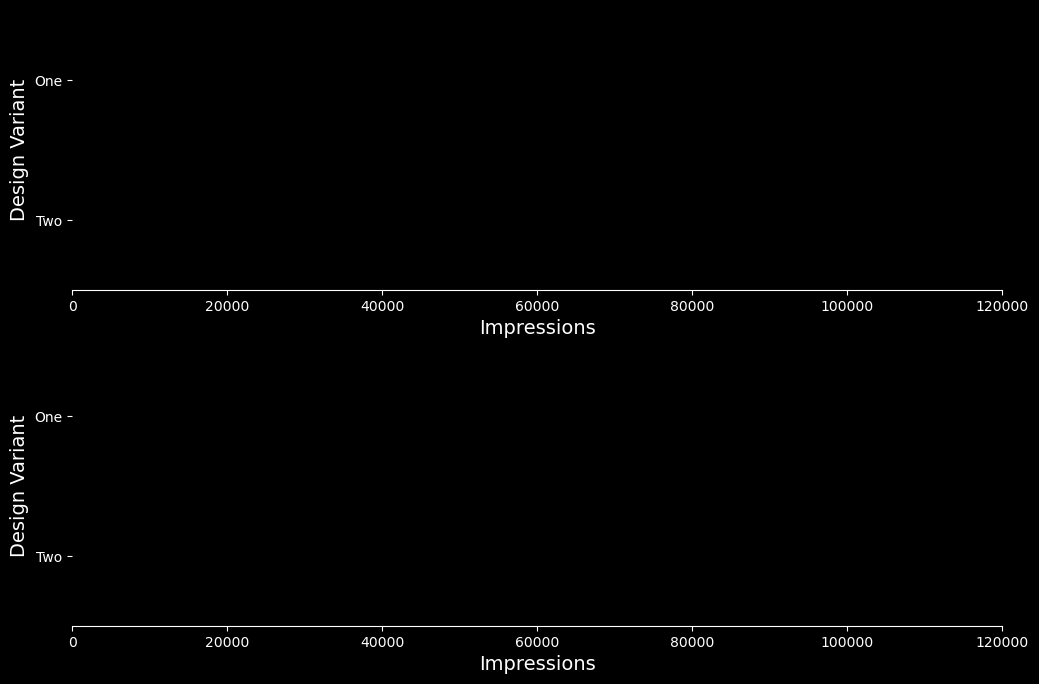

In [85]:
# Create an array with the colors you want to use

#UPDATE TO BE DYNAMIC
colors = ["#FF0B04", "#4374B3"]#, "#bd00ff"
plt.style.use("dark_background")
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

fig, (ax1, ax2) =plt.subplots(nrows=2, ncols =1, figsize=(12, 8))

step_size =1000

camera = Camera(fig)
for i in range(1, df.time_step.max()-1):
    if i % step_size == 0 :

        data=df.query('time_step == @i')
        data_ab=df_ab.query('time_step == @i+1')
        
        sent_to_worse = data.query('variant=="Two"')['action_cnt'].values[0]
        sent_to_worse_ab = data_ab.query('variant=="Two"')['action_cnt'].values[0]
        delta = sent_to_worse_ab - sent_to_worse
        ax1.set_xlim(0, 120000)
        sns.barplot(x="action_cnt", y="variant", data=data,
                 ax=ax1, palette = colors, hue = 'variant')

        ax1.set_ylabel('Design Variant', size=14)
        ax1.set_xlabel('Impressions', size=14)
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        ax1.text(0.7, 0.1, f'Better than AB test by:\n{delta:,.0f} Customers', transform=ax1.transAxes, color ='white', size=12)
       # ax1.text(0.7, 0.1, f'Sent to worse variant:\n{sent_to_worse:,.0f}', transform=ax1.transAxes, color ='white', size=12)
        #plt.title('Best variant is One', size=14)
        
        
        sns.barplot(x="action_cnt", y="variant", data=data_ab,
                ax=ax2, palette = colors, hue = 'variant')
        ax2.set_xlim(0, 120000)
        ax2.set_ylabel('Design Variant', size=14)
        ax2.set_xlabel('Impressions', size=14)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)


        camera.snap()
animation = camera.animate()
animation.save('celluloid_minimal.gif', writer = 'imagemagick')


In [74]:
data_ab

,time_step,variant,action_cnt
6000,3001,Zero,0
6001,3001,One,1001


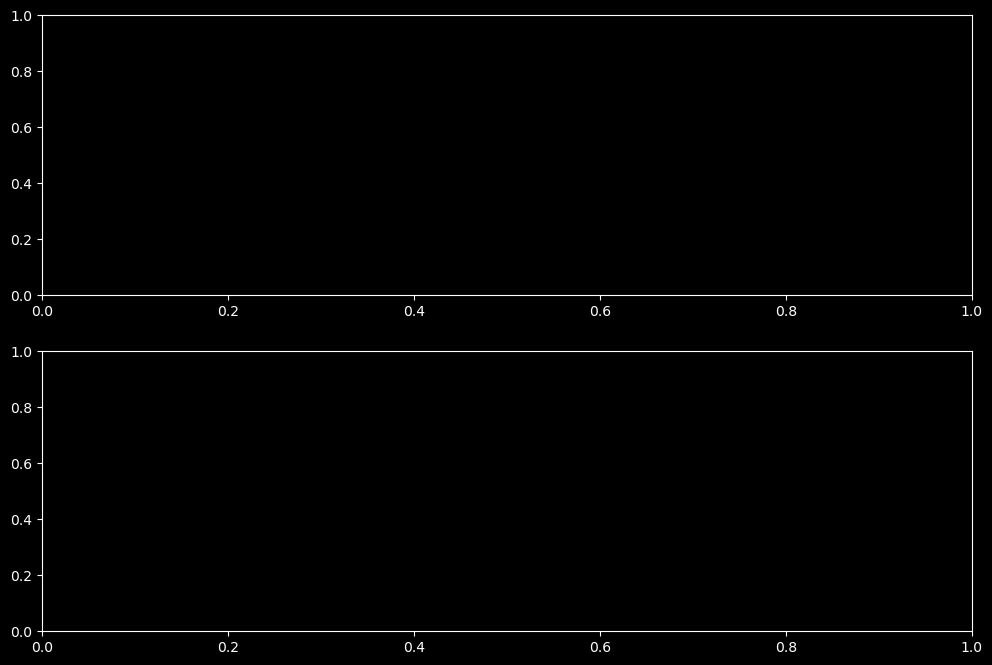

Text(0.4, 0.7, 'Correct Position')

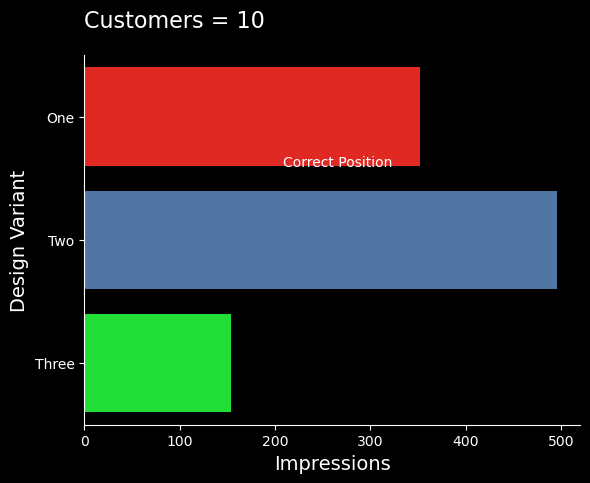

In [127]:
plt.style.use("dark_background")
fig, ax = plt.subplots()
sns.barplot(x="action_cnt", y="variant", data=df.query('time_step == 1000'),
                label="Total", ax=ax, palette = colors, hue = 'variant')

plt.ylabel('Design Variant', size=14)
plt.xlabel('Impressions', size=14)
plt.title("Customers = 10", size=16, loc='left', pad =20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(0.4, 0.7, 'Correct Position', transform=ax.transAxes, color ='white')




In [44]:
bandits